## Generative Latent Replay with GMMs

Code to test latent replay on benchmark problems and compare with proposed generative latent replay strategies i.e. normalising bottleneck representations and sampling from fitted GMM on latent space.

In [1]:
# ML imports
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torchvision import transforms

from avalanche.training import Naive, Replay

# from avalanche.models import SimpleMLP, SimpleCNN
from avalanche.benchmarks.classic import (
    RotatedMNIST,
    PermutedMNIST,
)  # ,PermutedOmniglot, RotatedOmniglot

import random
import numpy as np
from matplotlib import pyplot as plt

# Local imports
import models
import utils
from nets import SimpleCNN, SimpleMLP


In [2]:
# Config
SEED = 492
device = utils.get_device()

dataset = RotatedMNIST

model = "mlp"
n_classes = 10
n_epochs = 1
n_experiences = 3
input_size = 784
hidden_size = 64

n_hidden_layers = 1
freeze_depth = 0
assert freeze_depth <= n_hidden_layers
latent_layer_number = freeze_depth * 3
freeze_below_layer = "end_features.0"

replay_buffer_size = 60000

train_mb_size = 128
eval_mb_size = 512

# Reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

sanity_check_ablation_naive = {
    "latent_layer_number": 0,
    "replay_buffer_size": 0,
}
sanity_check_ablation_replay = {
    "latent_layer_number": 0,
    "replay_buffer_size": 1500,
}
sanity_check_ablation_latent_replay = {
    "latent_layer_number": 1,
    "replay_buffer_size": 1500,
}



In [3]:
# Prepare for training & testing
l2 = 0.0005
momentum = 0.9
lr = 0.001

# Model
model_2 = SimpleMLP(
    input_size=input_size,
    hidden_layers=n_hidden_layers,
    num_classes=n_classes,
    hidden_size=hidden_size,
)


# CL strategy
naive_strategy = Naive(
    model=model_2,
    criterion=CrossEntropyLoss(),
    optimizer=SGD(model_2.parameters(), lr=lr, momentum=momentum, weight_decay=l2),
    train_mb_size=train_mb_size,
    train_epochs=n_epochs,
    eval_mb_size=eval_mb_size,
    device=device,
)

replay_strategy = Replay(
    model=model_2,
    criterion=CrossEntropyLoss(),
    optimizer=SGD(model_2.parameters(), lr=lr, momentum=momentum, weight_decay=l2),
    train_mb_size=train_mb_size,
    train_epochs=n_epochs,
    eval_mb_size=eval_mb_size,
    device=device,
)



In [4]:
# Model
if model == "mlp":
    model = SimpleMLP(
        input_size=input_size,
        hidden_layers=n_hidden_layers,
        num_classes=n_classes,
        hidden_size=hidden_size,
    )
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))]
    )

elif model == "cnn":
    model = SimpleCNN(num_classes=n_classes)
    transform = transforms.Compose([transforms.ToTensor()])

else:
    # CL Benchmark Creation
    # Original AR1* usese CORE50 (n,3,128,128) and pretrained mobilenet
    transform = transforms.Compose(
        [
            # transforms.Lambda(lambda x: x.convert('RGB')),
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        ]
    )


# Prepare for training & testing

# Continual learning strategy
# cl_strategy = models.LatentReplay(criterion, train_mb_size=32, train_epochs=2, eval_mb_size=32, device=device)

cl_strategy = models.LatentReplay(
    model=model,
    criterion=CrossEntropyLoss(),
    rm_sz=replay_buffer_size,
    train_mb_size=train_mb_size,
    train_epochs=n_epochs,
    eval_mb_size=eval_mb_size,
    latent_layer_num=latent_layer_number,
    freeze_below_layer=freeze_below_layer,
    device=device,
)



FrozenNet(
  (lat_features): Sequential()
  (end_features): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)


c:\Users\jacob\Documents\GitHub\generative-latent-replay\models\ar1.py:112: UserWarning: The AR1 strategy implementation is in an alpha stage and is not perfectly aligned with the paper implementation. Please use at your own risk!
  warnings.warn(


In [5]:
for model, results in [
    (cl_strategy, (results_ar1 := [])),
    #(naive_strategy, (results_naive := [])),
    #(replay_strategy, (results_naive := [])),
]:
    experiences = dataset(
        n_experiences=n_experiences,
        train_transform=transform,
        eval_transform=transform,
        seed=SEED,
    )
    train_stream = experiences.train_stream
    test_stream = experiences.test_stream

    for train_exp in train_stream:
        model.train(train_exp)
        results.append(model.eval(train_stream))


-- >> Start of training phase << --
100%|██████████| 469/469 [00:18<00:00, 25.30it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.8458
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4728
Experience: 0
Current replay cache: 60000
Subset of cache to add: 60000
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from train stream --
100%|██████████| 118/118 [00:10<00:00, 11.43it/s]
> Eval on experience 0 (Task 0) from train stream ended.
	Loss_Exp/eval_phase/train_stream/Task000/Exp000 = 1.2275
	Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp000 = 0.7954
-- Starting eval on experience 1 (Task 1) from train stream --
100%|██████████| 118/118 [00:10<00:00, 10.84it/s]
> Eval on experience 1 (Task 1) from train stream ended.
	Loss_Exp/eval_phase/train_stream/Task001/Exp001 = 2.3176
	Top1_Acc_Exp/eval_phase/train_stream/Task001/Exp001 = 0.1078
-- Starting eval on experience 2 (Task 2) from train stream --
100%|█

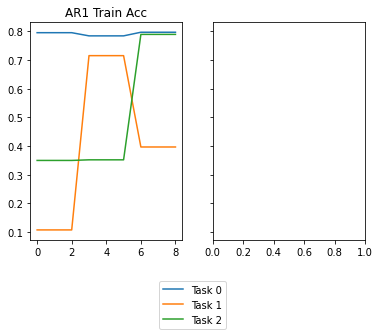

In [6]:
# JA: Next step - replace internal model.
# - model def ✅
# - frozen layer name ✅
# - batch renorm stuff...?

# JA: 2nd step
# - make GMM
# - add GMM to model sampler

fig, axes = plt.subplots(1, 2, sharey=True)
repeat_vals = 3

try:
    results_ar1_clean = utils.plot_results(
        results_ar1, "AR1", axes[0], n_experiences, "acc", repeat_vals=repeat_vals
    )
except:
    pass
try:
    results_naive_clean = utils.plot_results(
        results_naive, "Naive", axes[1], n_experiences, "acc", repeat_vals=repeat_vals
    )
except:
    pass
# results_ar1_clean = utils.plot_results(results_ar1, 'AR1', axes[1][0], 'loss')
# results_naive_clean = utils.plot_results(results_naive, 'Naive', axes[1][1], 'loss')

# print(results_ar1_clean["train"]['acc'])
# print(results_naive_clean["train"]['acc'])

utils.plot_single_legend(fig)
